# 1. Cài đặt thư viện

In [1]:
import os
print(os.getcwd())

d:\HCMUS_Document\Năm 3\Kì 1\Machine Learning\Lab_2\Intro2ML-HanhTrinhChuViet\lab2\source_code


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import cv2
import Evaluation as evaluation
import importlib
importlib.reload(evaluation)
import seaborn as sns

np.random.seed(42)

2. Tải dataset và xác định tập dữ liệu huấn luyện, kiểm thử

In [3]:
def load_mnist_binary(base_path):
    def read_idx(filename):
        with open(filename, 'rb') as f:
            zero, data_type, dims = struct.unpack('>HBB', f.read(4)) # extract header
            shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

    train_images = None
    train_labels = None
    test_images = None
    test_labels = None

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if 'train-images' in file and 'ubyte' in file:
                print(f"Found Training Images: {file}")
                train_images = read_idx(os.path.join(root, file))
            elif 'train-labels' in file and 'ubyte' in file:
                print(f"Found Training Labels: {file}")
                train_labels = read_idx(os.path.join(root, file))
            elif 't10k-images' in file and 'ubyte' in file:
                print(f"Found Test Images: {file}")
                test_images = read_idx(os.path.join(root, file))
            elif 't10k-labels' in file and 'ubyte' in file:
                print(f"Found Test Labels: {file}")
                test_labels = read_idx(os.path.join(root, file))

    if train_images is None:
        raise ValueError("Could not find 'train-images' binary file in the dataset.")

    return train_images, train_labels, test_images, test_labels

# Load the data
X_train_raw, y_train, X_test_raw, y_test = load_mnist_binary('./data')

print(f"Training Data: {X_train_raw.shape} (number of images, height, width), Labels: {y_train.shape}")
print(f"Test Data:     {X_test_raw.shape} (number of images, height, width), Labels: {y_test.shape}")

Found Test Images: t10k-images.idx3-ubyte
Found Test Labels: t10k-labels.idx1-ubyte
Found Training Images: train-images.idx3-ubyte
Found Training Labels: train-labels.idx1-ubyte
Training Data: (60000, 28, 28) (number of images, height, width), Labels: (60000,)
Test Data:     (10000, 28, 28) (number of images, height, width), Labels: (10000,)


# 3. EDA


1. Thông số cơ bản:
Số lượng ảnh mẫu: 60000
Kích thước mỗi ảnh: 28 x 28 pixels
Tổng số điểm ảnh (Features): 784
Giá trị pixel nhỏ nhất: 0
Giá trị pixel lớn nhất: 255
Kiểu dữ liệu: uint8


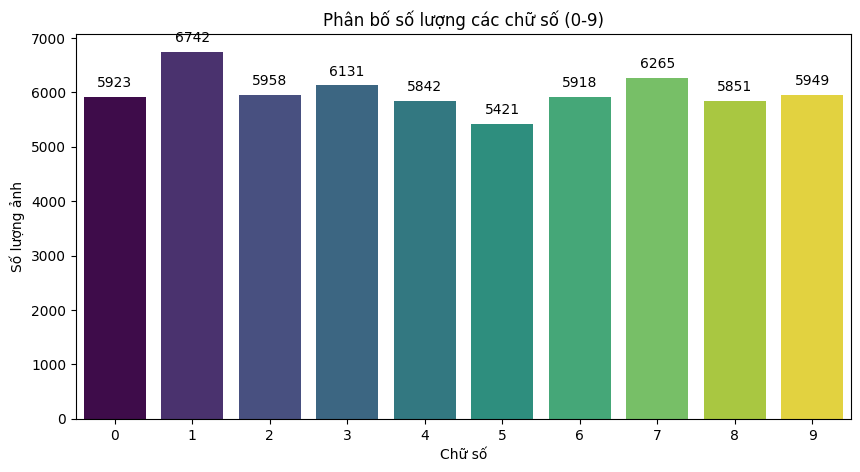


2. Hình dạng trung bình của từng nhãn:


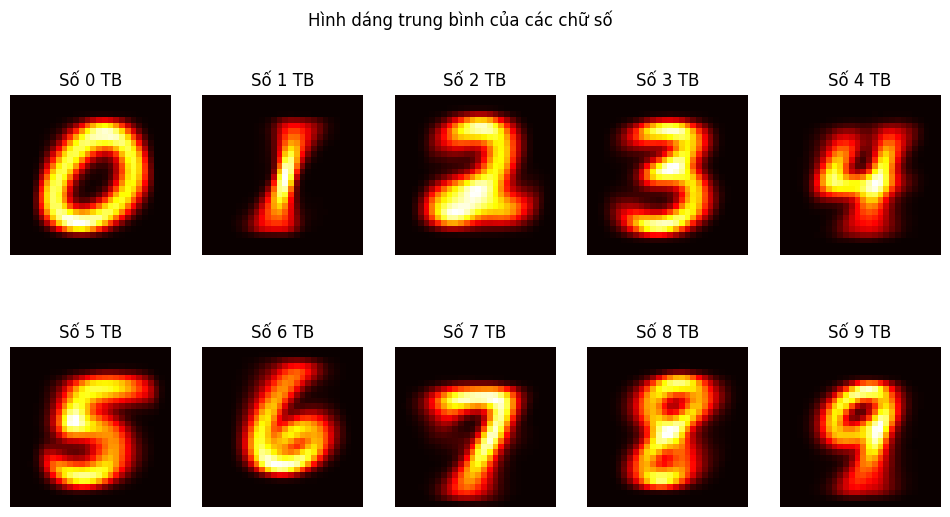


3. Một số hình minh họa:


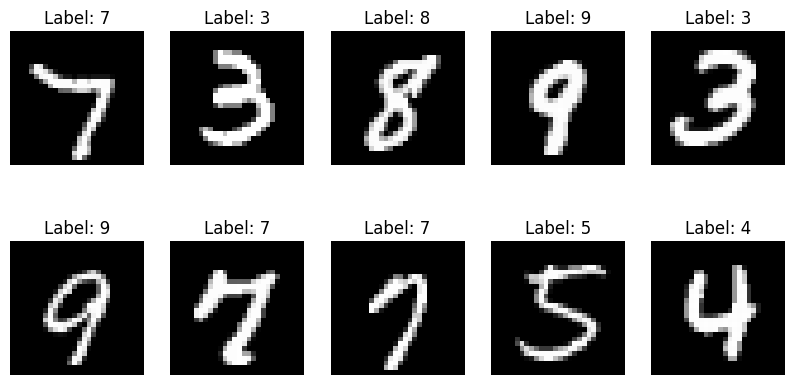

In [4]:
import seaborn as sns

def perform_detailed_eda(X, y, output_dir="EdgeBased_Sobel"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    n_samples, h, w = X.shape
    print(f"\n1. Thông số cơ bản:")
    print(f"Số lượng ảnh mẫu: {n_samples}")
    print(f"Kích thước mỗi ảnh: {h} x {w} pixels")
    print(f"Tổng số điểm ảnh (Features): {h * w}")
    print(f"Giá trị pixel nhỏ nhất: {np.min(X)}")
    print(f"Giá trị pixel lớn nhất: {np.max(X)}")
    print(f"Kiểu dữ liệu: {X.dtype}")

    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=y, hue=y, legend=False, palette="viridis")
    plt.title("Phân bố số lượng các chữ số (0-9)")
    plt.xlabel("Chữ số")
    plt.ylabel("Số lượng ảnh")

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    save_path1 = os.path.join(output_dir, "1_phan_bo_so_luong.png")
    plt.savefig(save_path1)
    plt.show()

    print("\n2. Hình dạng trung bình của từng nhãn:")
    plt.figure(figsize=(12, 6))
    for i in range(10):
        images_of_digit = X[y == i]
        mean_img = np.mean(images_of_digit, axis=0)

        plt.subplot(2, 5, i + 1)
        plt.imshow(mean_img, cmap='hot')
        plt.title(f"Số {i} TB")
        plt.axis('off')
    plt.suptitle("Hình dáng trung bình của các chữ số")

    save_path2 = os.path.join(output_dir, "2_hinh_dang_trung_binh.png")
    plt.savefig(save_path2)
    plt.show()

    print("\n3. Một số hình minh họa:")
    plt.figure(figsize=(10, 5))
    indices = np.random.choice(len(X), 10, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')

    save_path3 = os.path.join(output_dir, "3_mau_ngau_nhien.png")
    plt.savefig(save_path3)
    plt.show()

perform_detailed_eda(X_train_raw, y_train)

# 4. Trích xuất đặc trưng ảnh sử dụng Sobel và Tiền xử lý

Phương pháp ***Sobel***: là 1 kỹ thuật phát hiện cạnh, giúp làm nổi bật đường biên của chữ số và bỏ qua các thông tin nhiễu hoặc vùng nền không quan trọng.

**Quy trình xử lý:**
>
>**Chuyển đổi kiểu dữ liệu:** Các điểm ảnh đầu vào được chuyển sang dạng số thực (float64) để đảm bảo độ chính xác khi tính toán đạo hàm.
>
>**Tính Gradient:** Sử dụng bộ lọc Sobel với kích thước cửa sổ (Kernel $3 \times 3$) để tính đạo hàm theo hai phương:
>>
>>**Sobel X ($G_x$):** Phát hiện các cạnh dọc (sự thay đổi độ sáng theo chiều ngang).
>>
>>**Sobel Y ($G_y$):** Phát hiện các cạnh ngang (sự thay đổi độ sáng theo chiều dọc).
>
>**Tính Biên độ (Magnitude):** Kết hợp hai thành phần gradient để thu được độ mạnh tổng quát của cạnh tại mỗi điểm ảnh, sử dụng công thức Pytago:$$G = \sqrt{G_x^2 + G_y^2}$$
>
>**Chuẩn hóa (Normalization):** Chia toàn bộ ma trận biên độ cho giá trị lớn nhất để đưa các giá trị về khoảng $[0, 1]$. Điều này giúp thuật toán Gradient Descent hội tụ ổn định hơn.
>
>**Làm phẳng (Flattening):** Duỗi ma trận kết quả $28 \times 28$ thành vector đặc trưng 1 chiều có kích thước $784$.
>
>**Thêm hệ số Bias:** Sau khi có ma trận đặc trưng $X$, ta thêm một cột toàn số 1 vào phía trước. Điều này cho phép tích hợp vector tham số bias $b$ vào trong ma trận trọng số $W$, đơn giản hóa công thức mô hình tuyến tính từ $Z = W^T X + b$ thành $Z = W^T X$.

Final Feature Shape: (60000, 785)


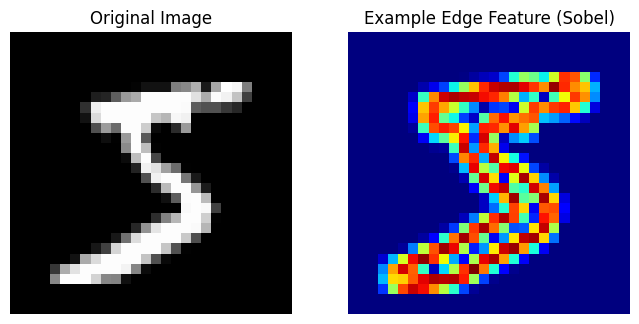

In [5]:
def extract_edge_features(images):
    """
    Applies Sobel to extract edge feature from (N, 28, 28) images.
    Returns flattened feature vectors (N, 784).
    """
    features = []

    for img in images:
        img_float = img.astype(np.float64)

        sobelx = cv2.Sobel(img_float, cv2.CV_64F, 1, 0, ksize=3) # đạo hàm theo trục x
        sobely = cv2.Sobel(img_float, cv2.CV_64F, 0, 1, ksize=3) # đạo hàm theo trục y

        magnitude = np.sqrt(sobelx**2 + sobely**2)

        max_val = np.max(magnitude)
        if max_val > 0:
            magnitude = magnitude / max_val

        features.append(magnitude.flatten())

    return np.array(features)

output_dir = "EdgeBased_Sobel"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

X_train_edges = extract_edge_features(X_train_raw)
X_test_edges = extract_edge_features(X_test_raw)

# Add Bias Term
X_train = np.c_[np.ones(len(X_train_edges)), X_train_edges]
X_test = np.c_[np.ones(len(X_test_edges)), X_test_edges]

print(f"Final Feature Shape: {X_train.shape}")

# Visualize one Edge Feature
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(X_train_raw[0], cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(X_train_edges[0].reshape(28, 28), cmap='jet')
axes[1].set_title("Example Edge Feature (Sobel)")
axes[1].axis('off')

save_path = os.path.join(output_dir, "4_example_edge_feature.png")
plt.savefig(save_path)
plt.show()

# 5. Cài đặt lớp SoftmaxRegression

**Danh sách hyperparameters:**
> `learning_rate` ($\alpha$): Tốc độ cập nhật trọng số.
>
> `n_iterations`: Số vòng lặp huấn luyện (Epochs).
>
> `n_classes`: Số lượng lớp đầu ra (với MNIST là 10 lớp).
>
> `weights`: Ma trận trọng số $W$, sẽ được khởi tạo khi bắt đầu train.

**Hàm kích hoạt Softmax:**

Chuyển đổi điểm số (score) thành xác suất.
>**Công thức:** $\hat{y}_k = \frac{e^{z_k}}{\sum_{j} e^{z_j}}$
>
>*Lưu ý:*
    Khi cài đặt, `z_shifted = z - np.max(z)`. Việc trừ đi giá trị lớn nhất giúp tránh hiện tượng tràn số (overflow) khi tính hàm mũ $e^z$ với các giá trị $z$ lớn.

**One_hot_encode:**
Chuyển đổi nhãn dạng số nguyên (ví dụ: `y=2`) sang vector xác suất mục tiêu (ví dụ: `[0, 0, 1, 0, ...]`). Điều này cần thiết để tính toán hàm mất mát Cross-Entropy.

**Huấn luyện mô hình (`fit`)**
Sử dụng thuật toán *Gradient Descent*:

1.  **Khởi tạo trọng số:** Tạo ma trận $W$ kích thước `(n_features, n_classes)` với toàn giá trị 0.
2.  **Vòng lặp:**
    * **Lan truyền xuôi (Forward Pass):**
        Tính toán điểm số $Z = X \cdot W$ và xác suất dự đoán $\hat{Y} = \text{softmax}(Z)$.
    * **Tính hàm mất mát (Compute Loss):**
        Sử dụng hàm **Cross-Entropy Loss**:
        $$J(W) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{C} y_{ik} \log(\hat{y}_{ik})$$
        *Lưu ý: Cộng thêm `1e-8` vào logarit để tránh lỗi log(0).*
    * **Tính Gradient (Backward Pass):**
        Tính đạo hàm của hàm mất mát theo trọng số $W$:
        $$\nabla_W J = \frac{1}{N} X^T (\hat{Y} - Y)$$
    * **Cập nhật trọng số (Update Parameters):**
        $$W = W - \alpha \cdot \nabla_W J$$

**Dự đoán (`predict`)**
Sau khi mô hình đã học được trọng số $W$ tối ưu:
1.  Tính xác suất cho dữ liệu mới: $\hat{Y} = \text{softmax}(X \cdot W)$.
2.  Chọn lớp có xác suất cao nhất: `np.argmax`.

In [6]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, n_iterations=1000, n_classes=10):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.n_classes = n_classes
        self.weights = None
        self.losses = []

    def softmax(self, z):
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        one_hot = np.zeros((len(y), self.n_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features, self.n_classes))
        y_encoded = self.one_hot_encode(y)

        for i in range(self.n_iterations):
            # Forward pass
            z = np.dot(X, self.weights)
            y_pred = self.softmax(z)

            # CE
            loss = -np.mean(np.sum(y_encoded * np.log(y_pred + 1e-8), axis=1))
            self.losses.append(loss)

            # Gradient
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_encoded))

            # Update
            self.weights -= self.lr * dw

            if (i+1) % 100 == 0:
                print(f"Iteration {i+1}, Loss: {loss:.4f}")

    def predict(self, X):
        z = np.dot(X, self.weights)
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)

# 6. Huấn luyện và Đánh giá

Iteration 100, Loss: 0.7397
Iteration 200, Loss: 0.5990
Iteration 300, Loss: 0.5427
Iteration 400, Loss: 0.5108
Iteration 500, Loss: 0.4897
Iteration 600, Loss: 0.4743
Iteration 700, Loss: 0.4624
Iteration 800, Loss: 0.4529
Iteration 900, Loss: 0.4450
Iteration 1000, Loss: 0.4383


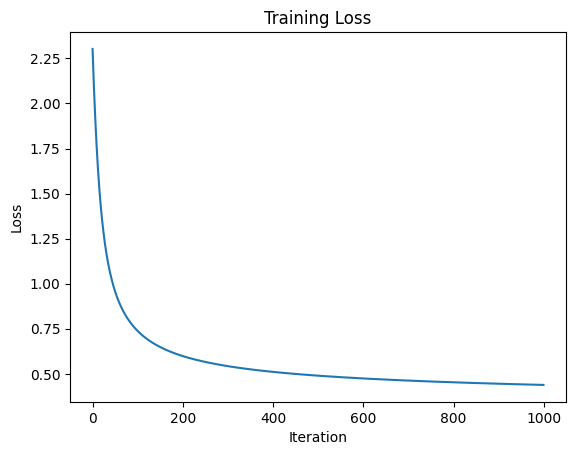


Evaluation Results
Training Accuracy: 0.8724
Test Accuracy: 0.8768

Classification Report (Test)
Precision: 0.8758
Recall: 0.8751
F1 Score: 0.8750


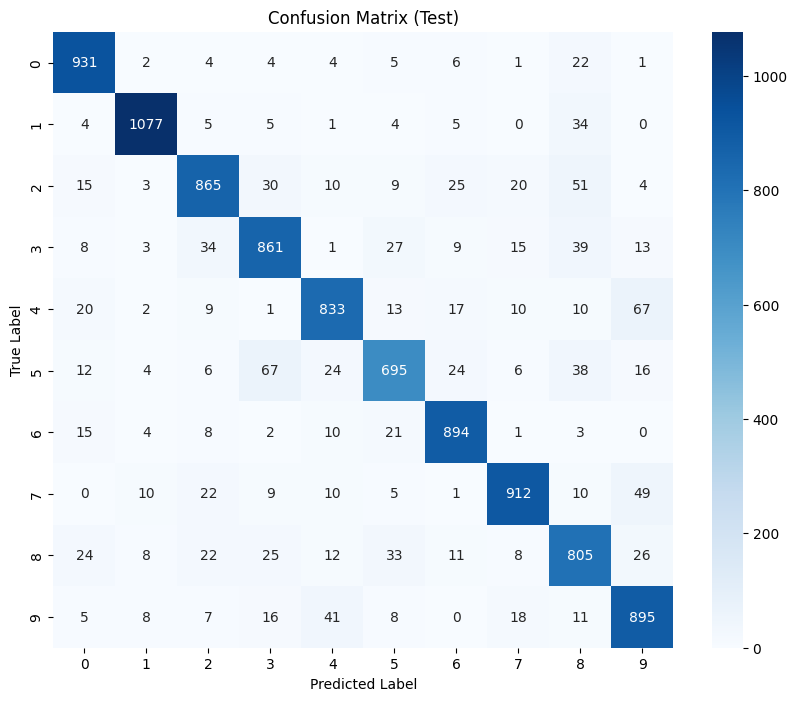

In [7]:
base_dir = "EdgeBased_Sobel"
model_dir = os.path.join(base_dir, "Model")

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model = SoftmaxRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X_train, y_train)

# Loss Curve
plt.plot(model.losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

loss_path = os.path.join(base_dir, "5_training_loss.png")
plt.savefig(loss_path)
plt.show()

# Evaluation
eval_train = evaluation.Evaluation(model, X_train, y_train)
eval_test = evaluation.Evaluation(model, X_test, y_test)

acc_train, precision_train, recall_train, f1_train, cm_train = eval_train.evaluate_model_multiclass()
acc_test, precision_test, recall_test, f1_test, cm_test = eval_test.evaluate_model_multiclass()

print("\nEvaluation Results")
print(f"Training Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

print("\nClassification Report (Test)")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")


# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = cm_test
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)") 
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

cm_path = os.path.join(base_dir, "6_confusion_matrix.png")
plt.savefig(cm_path)
plt.show()

weights_path = os.path.join(model_dir, "weights.npy")
np.save(weights_path, model.weights)